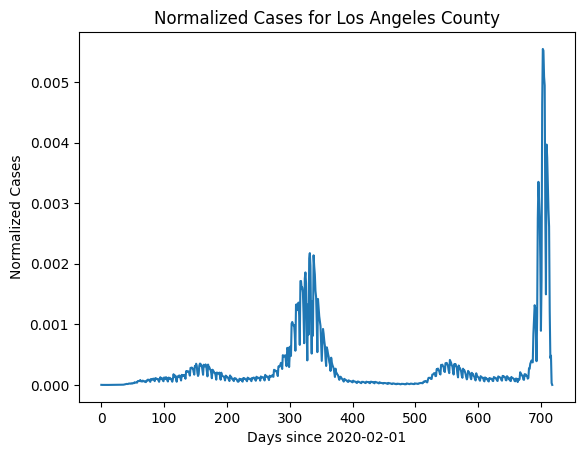

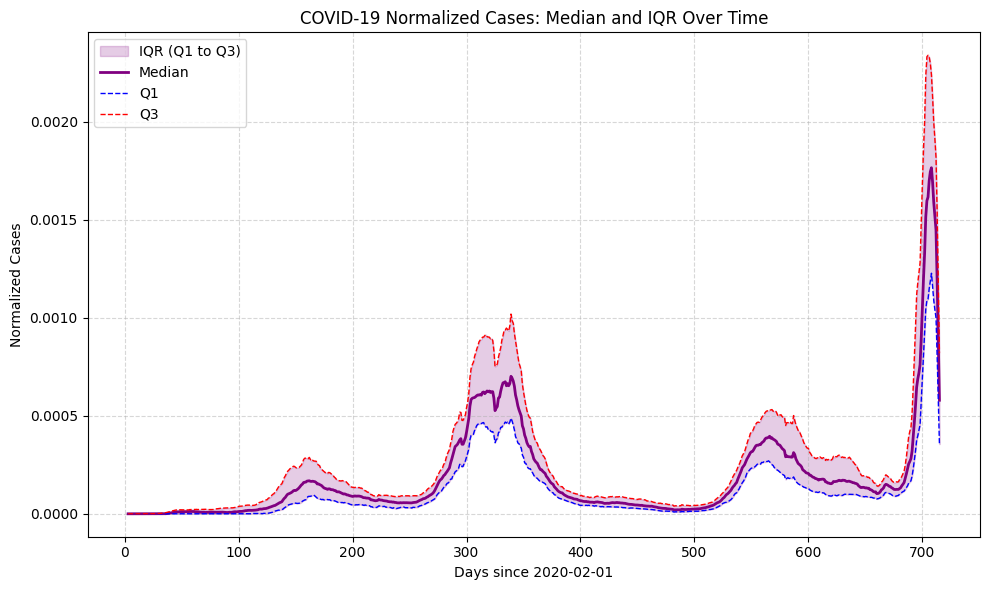

In [8]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Step 1: Import the data
data_url = "https://raw.githubusercontent.com/jswelling/CMU-MS-DAS-Vis-S25/refs/heads/main/data/covid19cases_test.csv"
df = pd.read_csv(data_url)

# Step 2: Create a date_offset column
def compute_date_offset(date_str):
    if pd.isna(date_str):
        return math.nan
    base_date = datetime.strptime("2020-02-01", "%Y-%m-%d")
    current_date = datetime.strptime(date_str, "%Y-%m-%d")
    return (current_date - base_date).days

df['date_offset'] = df['date'].apply(compute_date_offset)

# Step 3: Normalize the case counts
df['normalized_cases'] = df['cases'] / df['population']

# Step 4: Quick plot for one county (Optional, for testing)
one_county_df = df[df['area'] == 'Los Angeles']
fig, axes = plt.subplots()
axes.plot(one_county_df['date_offset'], one_county_df['normalized_cases'])
plt.title("Normalized Cases for Los Angeles County")
plt.xlabel("Days since 2020-02-01")
plt.ylabel("Normalized Cases")
plt.show()

# Step 5: Statistical Summaries
safe_cols_df = df.drop(columns=['date', 'area', 'area_type'])
medians_df = safe_cols_df.groupby('date_offset').median().reset_index()
quartiles_df = safe_cols_df.groupby('date_offset')['normalized_cases'].quantile([0.25, 0.75]).unstack()
quartiles_df.columns = ['Q1', 'Q3']
quartiles_df = quartiles_df.reset_index()

# Step 6: Apply a running average
medians_df['smoothed_median'] = medians_df['normalized_cases'].rolling(window=7, center=True).mean()
quartiles_df['smoothed_Q1'] = quartiles_df['Q1'].rolling(window=7, center=True).mean()
quartiles_df['smoothed_Q3'] = quartiles_df['Q3'].rolling(window=7, center=True).mean()

# Step 7: Draw the final graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(
    quartiles_df['date_offset'],
    quartiles_df['smoothed_Q1'],
    quartiles_df['smoothed_Q3'],
    color='purple',
    alpha=0.2,
    label="IQR (Q1 to Q3)"
)
ax.plot(medians_df['date_offset'], medians_df['smoothed_median'], color='purple', linewidth=2, label='Median')
ax.plot(quartiles_df['date_offset'], quartiles_df['smoothed_Q1'], color='blue', linestyle='--', linewidth=1, label='Q1')
ax.plot(quartiles_df['date_offset'], quartiles_df['smoothed_Q3'], color='red', linestyle='--', linewidth=1, label='Q3')

# Step 8: Labels and such
plt.title("COVID-19 Normalized Cases: Median and IQR Over Time")
plt.xlabel("Days since 2020-02-01")
plt.ylabel("Normalized Cases")
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
